In [11]:
import pyspark

In [12]:
myConf=pyspark.SparkConf()
spark=pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

# 13주 iris데이터 회귀분석




## (1) DataFrame 생성

In [41]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [42]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## (2) 회귀선 그래프

In [43]:
from sklearn import linear_model
x=iris['petal_length']
y=iris['petal_width']

In [44]:
import numpy as np
x=np.array([x,np.ones(len(x))])
x=x.T
w1, w0=np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))

In [45]:
yhat = w0*x[:,1] + w1*x[:,0]

In [46]:
alpha = 0.0001
theta=np.array(np.ones([x.shape[1]]))

In [23]:
def gradientDescent(x, y, theta, alpha, numIterations):
    for i in range(numIterations):
        h=np.dot(x, theta)
        error=h-y
        cost=np.sum((h-y)**2) / len(x) # full MSE
        gradient=np.dot(x.T,error)*2/len(x) # w0, w1
        theta-=alpha*gradient
        if (i%100==0):
            print ("iter:{0:5d}\ttheta {1} Cost {2:.5f}".format(i, theta, cost))
    return theta

In [47]:
w1, w0=gradientDescent(x, y, theta, alpha, 10000)

iter:    0	theta [0.99696289 0.999288  ] Cost 13.76907
iter:  100	theta [0.74270901 0.93899892] Cost 6.82932
iter:  200	theta [0.56587746 0.89579339] Cost 3.46148
iter:  300	theta [0.44297297 0.86449143] Cost 1.82664
iter:  400	theta [0.35763005 0.84148495] Cost 1.03260
iter:  500	theta [0.29844945 0.82426073] Cost 0.64651
iter:  600	theta [0.25749113 0.81106821] Cost 0.45834
iter:  700	theta [0.2292245  0.80068803] Cost 0.36621
iter:  800	theta [0.20979727 0.79227083] Cost 0.32068
iter:  900	theta [0.19652617 0.785225  ] Cost 0.29776
iter: 1000	theta [0.18754218 0.77913844] Cost 0.28581
iter: 1100	theta [0.18154345 0.77372407] Cost 0.27920
iter: 1200	theta [0.1776232  0.76878193] Cost 0.27518
iter: 1300	theta [0.17514983 0.76417273] Cost 0.27243
iter: 1400	theta [0.17368337 0.75979943] Cost 0.27029
iter: 1500	theta [0.1729174  0.75559441] Cost 0.26846
iter: 1600	theta [0.17263848 0.75151058] Cost 0.26678
iter: 1700	theta [0.17269794 0.74751512] Cost 0.26518
iter: 1800	theta [0.1729922

In [48]:
yhatGV = w0*x[:,1] + w1*x[:,0]

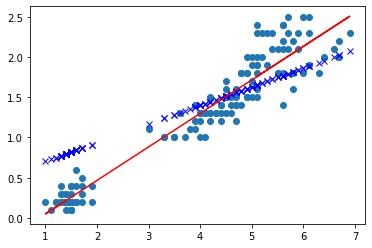

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x[:,0],y)
plt.plot(x[:,0],yhatGV,'bx') # gradient, MSE=123
plt.plot(x[:,0],yhat,'r-') # matrix inverse, MSE=105.6
plt.show()

## (3) Spark를 사용하여 회귀분석하고 계수 출력

In [51]:
irisDf=spark.createDataFrame(iris)

In [52]:
train, test = irisDf.randomSplit([0.6, 0.4])

In [53]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["petal_length"],
                                   outputCol = 'features')

In [54]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [55]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[va,lr])

In [58]:
model = pipeline.fit(train)
modelTrainDf = model.transform(train)

In [59]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.25419918577379963]
Intercept: 0.226


## (4) 실제와 예측 출력

In [60]:
modelTest=model.transform(test)

In [64]:
modelTest.select('petal_width','prediction').show(10)

+-----------+-------------------+
|petal_width|         prediction|
+-----------+-------------------+
|        0.1|  0.505379303593392|
|        0.3| 0.5562191407481519|
|        0.3| 0.5816390593255318|
|        0.2|0.47995938501601204|
|        0.2| 0.6324788964802919|
|        0.3| 0.5816390593255318|
|        0.2| 0.7087386522124317|
|        1.7| 1.3696565352243109|
|        0.2| 0.5816390593255318|
|        1.0| 1.1154573494505111|
+-----------+-------------------+
only showing top 10 rows



In [66]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [67]:
rmse=evaluator.evaluate(modelTest)

In [68]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.366'

In [69]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="r2")

In [71]:
f"r2: {evaluator.evaluate(modelTest):.3f}"

'r2: 0.779'